## Introduction to Data Science

### Predictive Analysis - numerical and categorical data

#### The sinking of Titanic  
Based on [this](https://www.kaggle.com/c/titanic-gettingStarted) Kaggle Competition. Inspired by a handful of solutions, like [this one](https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8)

In [135]:
import os
import sys
import time
import pickle
import itertools
import pandas as pd
import numpy as np
import pylab
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline
#%matplotlib notebook
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')

In [2]:
## Optional -- testing GPU support to tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))  ## output on console
print(device_lib.list_local_devices())

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17641059320036484534
]


### The Might Titanic !

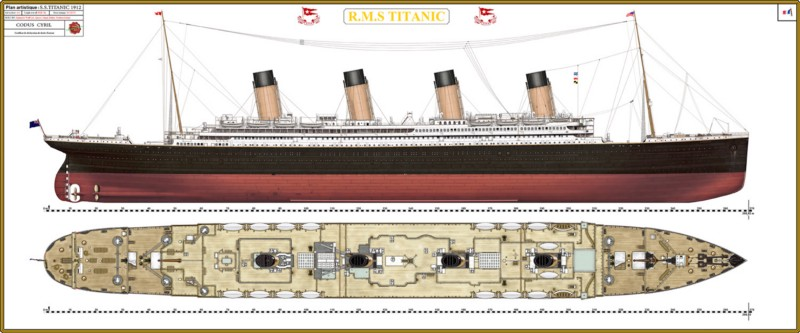

In [3]:
Image(filename='../datasets/Figs/titanic.jpeg')

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

SPECIAL NOTES:
Pclass is a proxy for socio-economic status (SES)
 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

Age is in Years; Fractional if Age less than One (1)
 If the Age is Estimated, it is in the form xx.5

With respect to the family relation variables (i.e. sibsp and parch)
some relations were ignored.  The following are the definitions used
for sibsp and parch.

Sibling:  Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic
Spouse:   Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored)
Parent:   Mother or Father of Passenger Aboard Titanic
Child:    Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic

Other family relatives excluded from this study include cousins,
nephews/nieces, aunts/uncles, and in-laws.  Some children travelled
only with a nanny, therefore parch=0 for them.  As well, some
travelled with very close friends or neighbors in a village, however,
the definitions do not support such relations.

#### Importing the datasets

In [4]:
datapath = "../datasets/"
outputs = "../outputs/"

In [5]:
df_train = pd.read_csv(os.path.join(datapath,'Kaggle/Titanic/kaggle_titanic_train.csv'))
df_test = pd.read_csv(os.path.join(datapath,'Kaggle/Titanic/kaggle_titanic_test.csv'))

#### Exploring Data

In [6]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [9]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='int64')]

PassengerId    int64
Survived       int64
Pclass         int64
SibSp          int64
Parch          int64
dtype: object

In [10]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='float64')]

Age     float64
Fare    float64
dtype: object

In [11]:
df_train.dtypes[df_train.dtypes.map(lambda x: x=='object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [12]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [13]:
for cat in df_train.columns:
    print("Number of levels in category '{0}': \b {1:2.2f} ".format(cat, df_train[cat].unique().size))

Number of levels in category 'PassengerId': 891.00 
Number of levels in category 'Survived': 2.00 
Number of levels in category 'Pclass': 3.00 
Number of levels in category 'Name': 891.00 
Number of levels in category 'Sex': 2.00 
Number of levels in category 'Age': 89.00 
Number of levels in category 'SibSp': 7.00 
Number of levels in category 'Parch': 7.00 
Number of levels in category 'Ticket': 681.00 
Number of levels in category 'Fare': 248.00 
Number of levels in category 'Cabin': 148.00 
Number of levels in category 'Embarked': 4.00 


#### Describing the numeric values

In [14]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


#### Examining the categorical values

In [15]:
# There are many values for name and ticket

for cat in ['Sex', 'Survived', 'Pclass', 'SibSp', 'Embarked', 'Cabin']:
    print("Unique values for category '{0}': \b {1} ".format(cat, df_train[cat].unique()))

Unique values for category 'Sex': ['male' 'female'] 
Unique values for category 'Survived': [0 1] 
Unique values for category 'Pclass': [3 1 2] 
Unique values for category 'SibSp': [1 0 3 4 2 5 8] 
Unique values for category 'Embarked': ['S' 'C' 'Q' nan] 
Unique values for category 'Cabin': [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A2

In [16]:
print(df_train.Survived.value_counts())

0    549
1    342
Name: Survived, dtype: int64


#### Survived by sex:

In [17]:
df_train.groupby('Sex').Survived.value_counts()

Sex     Survived
female  1           233
        0            81
male    0           468
        1           109
Name: Survived, dtype: int64

In [18]:
df_by_sex = df_train.groupby('Sex')
df_by_sex.describe()

Age                                                       Fare  \
        count       mean        std   min   25%   50%   75%   max  count   
Sex                                                                        
female  261.0  27.915709  14.110146  0.75  18.0  27.0  37.0  63.0  314.0   
male    453.0  30.726645  14.678201  0.42  21.0  29.0  39.0  80.0  577.0   

                  ...  SibSp      Survived                                     \
             mean ...    75%  max    count      mean       std  min  25%  50%   
Sex               ...                                                           
female  44.479818 ...    1.0  8.0    314.0  0.742038  0.438211  0.0  0.0  1.0   
male    25.523893 ...    0.0  8.0    577.0  0.188908  0.391775  0.0  0.0  0.0   

                  
        75%  max  
Sex               
female  1.0  1.0  
male    0.0  1.0  

[2 rows x 56 columns]

In [19]:
# Split the survived passengers to male and female
males = df_train[df_train['Sex'] == 'male']
survived_males = df_train[(df_train['Sex']=='male')&(df_train['Survived']==1)]

females = df_train[df_train['Sex'] == 'female']
survived_females = df_train[(df_train['Sex']=='female')&(df_train['Survived']==1)]

1    233
0     81
Name: Survived, dtype: int64


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,1,'Density Plot of Female Titanic Passengers by Age')

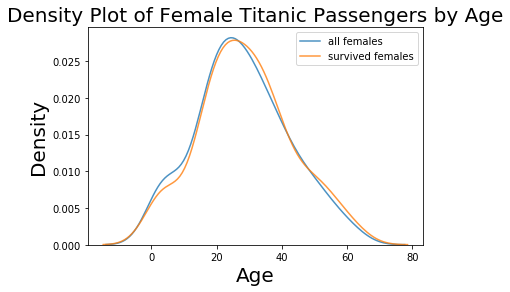

In [20]:
print(females["Survived"].value_counts())

sns.kdeplot(females['Age'], label = 'all females', shade = False, alpha = 0.8)
sns.kdeplot(survived_females['Age'], label = 'survived females', shade = False, alpha = 0.8)

# label the plot
plt.xlabel('Age', size = 20)
plt.ylabel('Density', size = 20)
plt.title('Density Plot of Female Titanic Passengers by Age', size = 20)

0    468
1    109
Name: Survived, dtype: int64


/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5,1,'Density Plot of Male Titanic Passengers by Age')

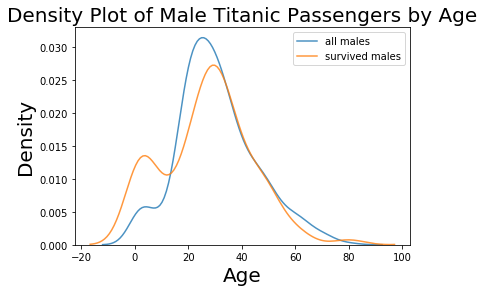

In [21]:
print(males["Survived"].value_counts())

sns.kdeplot(males['Age'], label = 'all males', shade = False, alpha = 0.8)
sns.kdeplot(survived_males['Age'], label = 'survived males', shade = False, alpha = 0.8)

# label the plot
plt.xlabel('Age', size = 20); plt.ylabel('Density', size = 20)
plt.title('Density Plot of Male Titanic Passengers by Age', size = 20)

#### Survived by Pclass

In [22]:
df_train.groupby('Pclass').Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [23]:
df_train.groupby(['Pclass']).Survived.value_counts()

Pclass  Survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64

In [24]:
df_by_class = df_train.groupby('Pclass')
df_by_class.describe()

Age                                                       Fare  \
        count       mean        std   min   25%   50%   75%   max  count   
Pclass                                                                     
1       186.0  38.233441  14.802856  0.92  27.0  37.0  49.0  80.0  216.0   
2       173.0  29.877630  14.001077  0.67  23.0  29.0  36.0  70.0  184.0   
3       355.0  25.140620  12.495398  0.42  18.0  24.0  32.0  74.0  491.0   

                  ...  SibSp      Survived                                     \
             mean ...    75%  max    count      mean       std  min  25%  50%   
Pclass            ...                                                           
1       84.154687 ...    1.0  3.0    216.0  0.629630  0.484026  0.0  0.0  1.0   
2       20.662183 ...    1.0  3.0    184.0  0.472826  0.500623  0.0  0.0  0.0   
3       13.675550 ...    1.0  8.0    491.0  0.242363  0.428949  0.0  0.0  0.0   

                  
        75%  max  
Pclass            
1       1.0  1.0  
2       1.0  1.0  
3       0.0  1.0  

[3 rows x 48 columns]

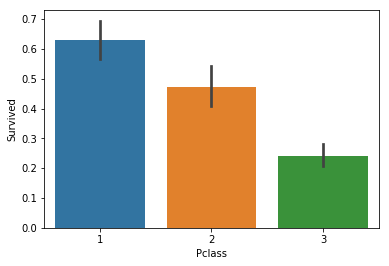

In [25]:
sns.barplot(x='Pclass', y='Survived', data=df_train)

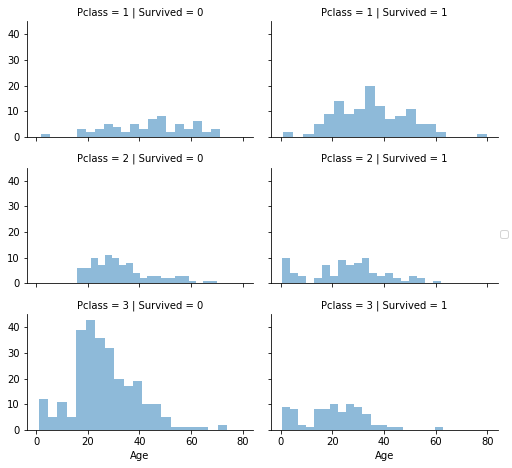

In [26]:
grid = sns.FacetGrid(df_train, col='Survived', row='Pclass', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

#### Survived by Age

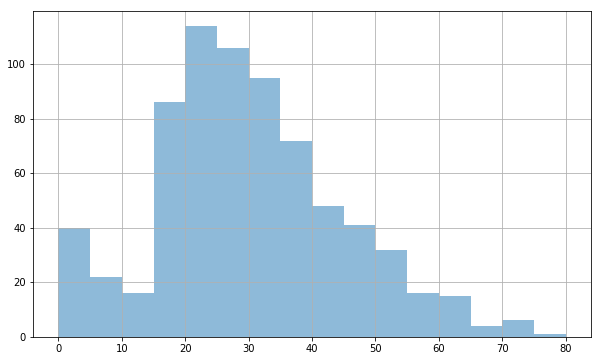

In [27]:
#df_train['Age'].hist()
df_train['Age'].dropna().hist(bins=16, range=(0,80), alpha = .5, figsize=(10,6))

In [28]:
ser, bins = pd.qcut(df_train.Age.dropna(), 5, retbins=True, labels=False)
print(bins)
df_train.groupby(ser).Survived.value_counts()

[ 0.42 19.   25.   31.8  41.   80.  ]


Age  Survived
0.0  0           85
     1           79
1.0  0           92
     1           45
2.0  0           77
     1           50
3.0  0           81
     1           63
4.0  0           89
     1           53
Name: Survived, dtype: int64

#### Sex and Pclass

In [29]:
df_train.groupby(['Pclass']).Sex.value_counts()

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

In [30]:
df_train.groupby(['Pclass','Sex']).Survived.value_counts()

Pclass  Sex     Survived
1       female  1            91
                0             3
        male    0            77
                1            45
2       female  1            70
                0             6
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

In [31]:
id = pd.crosstab([df_train.Pclass, df_train.Sex], df_train.Survived.astype(float))
id.columns = (['No', 'Yes'])
id.columns.name = "Survived"
id.div(id.sum(1).astype(float), 0)

Survived             No       Yes
Pclass Sex                       
1      female  0.031915  0.968085
       male    0.631148  0.368852
2      female  0.078947  0.921053
       male    0.842593  0.157407
3      female  0.500000  0.500000
       male    0.864553  0.135447

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


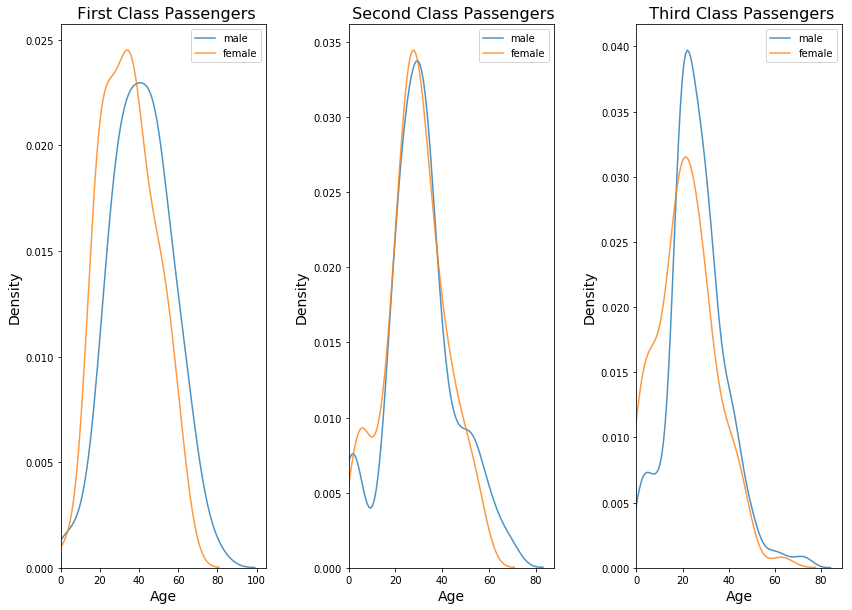

In [32]:
# Set-up 3x2 grid for plotting.

fig, sub = plt.subplots(1,3, figsize=(14,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" First Class "," Second Class "," Third Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = males[males['Pclass']==i]
    female_data = females[females['Pclass']==i]
    
    plt_title = title + 'Passengers'
    sns.kdeplot(male_data['Age'],
               label = 'male', shade = False, alpha = 0.8,ax=ax);
    sns.kdeplot(female_data['Age'],
               label = 'female', shade = False, alpha = 0.8, ax=ax)
    
    ax.set_xlabel('Age', size = 14)
    ax.set_ylabel('Density', size = 14)
    ax.set_title(plt_title, size = 16)
    ax.set(xlim=(0))
  
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


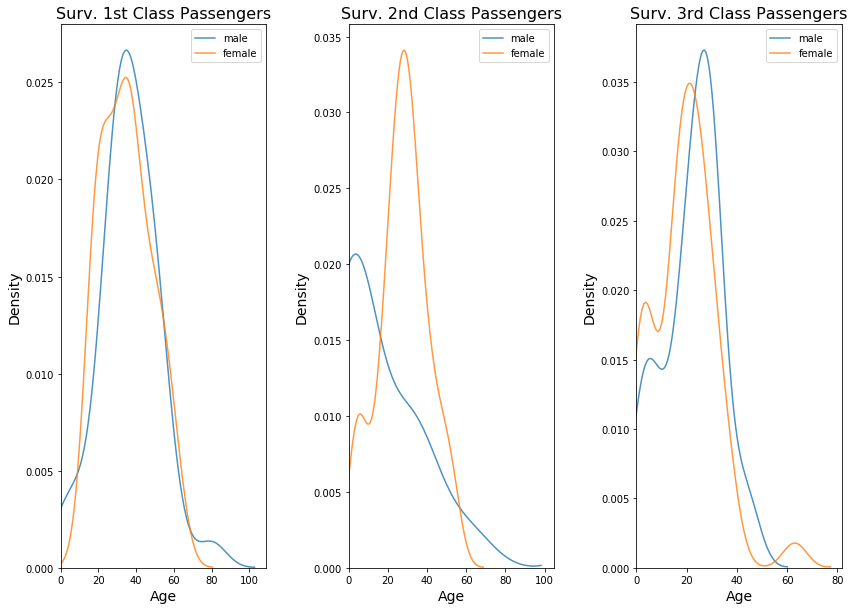

In [33]:
# Set-up 3x2 grid for plotting.

fig, sub = plt.subplots(1,3, figsize=(14,10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

titles = [" 1st Class "," 2nd Class "," 3rd Class "]

for i, title, ax in zip([1,2,3], titles, sub.flatten()):
    male_data = survived_males[survived_males['Pclass']==i]
    female_data = survived_females[survived_females['Pclass']==i]
    
    plt_title = 'Surv.'+ title + 'Passengers'
    sns.kdeplot(male_data['Age'],
               label = 'male', shade = False, alpha = 0.8,ax=ax);
    ax.set_xlabel('Age', size = 14)
    sns.kdeplot(female_data['Age'],
               label = 'female', shade = False, alpha = 0.8, ax=ax)
    ax.set_xlabel('Age', size = 14)
    ax.set_ylabel('Density', size = 14)
    ax.set_title(plt_title, size = 16)
    ax.set(xlim=(0))
  
plt.show()

#### Dealing with missing values

In [34]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent_1 = df_train.isnull().sum()/df_train.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(5)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


#### Codifying "Sex" field

In [35]:
df_train['Gender'] = df_train['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
df_test['Gender'] = df_test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

#### Filling the null values for Age

In [36]:
print(len(df_train[df_train['Age'].isnull()]))
print(len(df_test[df_test['Age'].isnull()]))

177
86


In [37]:
df_train['AgeFill'] = df_train['Age']
df_test['AgeFill'] = df_test['Age']

In [38]:
df_train[df_train['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(4)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,NaN
17,1,2,NaN,NaN
19,0,3,NaN,NaN
26,1,3,NaN,NaN


In [39]:
median_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df_train[(df_train['Gender'] == i) & (df_train['Pclass'] == j+1)]['Age'].dropna().median()

median_ages

array([[35. , 28. , 21.5],
       [40. , 30. , 25. ]])

In [40]:
for i in range(0, 2):
    for j in range(0, 3):
        df_train.loc[(df_train.Age.isnull()) & (df_train.Gender == i) & (df_train.Pclass == j+1),'AgeFill'] = median_ages[i,j]
        df_test.loc[(df_test.Age.isnull()) & (df_test.Gender == i) & (df_test.Pclass == j+1),'AgeFill'] = median_ages[i,j]

In [41]:
df_train[df_train['Age'].isnull()][['Gender','Pclass','Age','AgeFill']].head(4)

,Gender,Pclass,Age,AgeFill
5,1,3,NaN,25.0
17,1,2,NaN,30.0
19,0,3,NaN,21.5
26,1,3,NaN,25.0


#### Filling the null values for "Embarked"

In [42]:
df_train[df_train['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,0,38.0
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,0,62.0


In [43]:
df_train[59:64]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
59,60,0,3,"Goodwin, Master. William Frederick",male,11.0,5,2,CA 2144,46.9000,NaN,S,1,11.0
60,61,0,3,"Sirayanian, Mr. Orsen",male,22.0,0,0,2669,7.2292,NaN,C,1,22.0
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN,0,38.0
62,63,0,1,"Harris, Mr. Henry Birkhardt",male,45.0,1,0,36973,83.4750,C83,S,1,45.0
63,64,0,3,"Skoog, Master. Harald",male,4.0,3,2,347088,27.9000,NaN,S,1,4.0


In [44]:
df_train[826:832]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S,1,25.00
827,828,1,2,"Mallet, Master. Andre",male,1.00,0,2,S.C./PARIS 2079,37.0042,NaN,C,1,1.00
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,1,25.00
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN,0,62.00
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.00,1,0,2659,14.4542,NaN,C,0,15.00
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S,1,0.83


##### Associating the missing values to the most likely class

In [45]:
df_train['Embarked'] = df_train['Embarked'].map({np.nan:1,'C':1, 'Q':2,'S':3} ).astype(int)
df_test['Embarked'] = df_test['Embarked'].map({np.nan:1,'C':1, 'Q':2,'S':3} ).astype(int)

#### One-Hot-Enconding the field "Embarked"

In [46]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
lb = LabelBinarizer()
mlb = MultiLabelBinarizer()

In [47]:
df_train.groupby(['Embarked']).Survived.value_counts()

Embarked  Survived
1         1            95
          0            75
2         0            47
          1            30
3         0           427
          1           217
Name: Survived, dtype: int64

In [48]:
df_train.groupby(['Embarked']).Fare.mean()

Embarked
1    60.189978
2    13.276030
3    27.079812
Name: Fare, dtype: float64

In [49]:
embarked = pd.DataFrame(lb.fit_transform(df_train['Embarked'].values), columns=['Emb1','Emb2','Emb3'])
df_train = pd.concat([df_train, embarked], axis=1)

In [50]:
embarked = pd.DataFrame(lb.fit_transform(df_test['Embarked'].values), columns=['Emb1','Emb2','Emb3'])
df_test = pd.concat([df_test, embarked], axis=1)

#### One-Hot-Enconding the field "Cabin"

In [51]:
df_train['Cabin'].value_counts()

G6                 4
C23 C25 C27        4
B96 B98            4
D                  3
F2                 3
F33                3
E101               3
C22 C26            3
B22                2
C68                2
E121               2
D36                2
C93                2
C2                 2
B35                2
D26                2
E33                2
C52                2
C65                2
C124               2
B51 B53 B55        2
C123               2
B57 B59 B63 B66    2
B28                2
C92                2
E25                2
F4                 2
B77                2
C126               2
C78                2
                  ..
A32                1
E40                1
D37                1
D49                1
B69                1
D11                1
D15                1
E49                1
B42                1
C46                1
C50                1
C118               1
E63                1
C91                1
A19                1
A24                1
E36          

In [52]:
CabinTrans = pd.DataFrame(mlb.fit_transform([{str(val)} for val in df_train['Cabin'].values]))

In [53]:
CabinTrans.head()

,0,1,2,3,4,5,6,7,8,9,...,138,139,140,141,142,143,144,145,146,147
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### We give up using the Cabin feature as is, using traditional hot-encoding...

In [54]:
#df_train = pd.concat([df_train, CabinTrans], axis=1)

... but
After doing some research, we could know that a cabin number looks like ‘C123’ and the letter refers to the deck. Therefore we’re could extract these and create a new feature, that contains a persons deck. Afterwords we will convert the feature into a numeric variable.

In [55]:
import re
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [df_train, df_test]

for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

In [56]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,AgeFill,Emb1,Emb2,Emb3,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U0,3,1,22.0,0,0,1,8
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,1,0,38.0,1,0,0,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U0,3,0,26.0,0,0,1,8
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,3,0,35.0,0,0,1,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U0,3,1,35.0,0,0,1,8


#### Creating a feature for number of relatives

In [57]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch']
df_train['Age*Class'] = df_train.AgeFill * df_train.Pclass

df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch']
df_test['Age*Class'] = df_test.AgeFill * df_test.Pclass

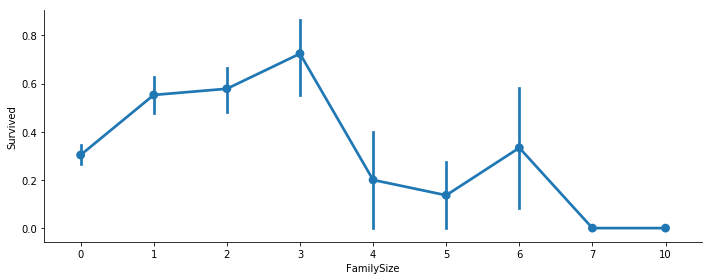

In [58]:
axes = sns.factorplot('FamilySize','Survived', data=df_train, aspect = 2.5, )

#### Extract the Titles from "Name", so that we can build a new feature out of that. (TBD)

#### Fare per Person (TBD)

for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['FamilySize']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

df_train.head(10)

#### Ticket

In [59]:
df_train['Ticket'].describe()

count          891
unique         681
top       CA. 2343
freq             7
Name: Ticket, dtype: object

Since the Ticket attribute has 681 unique tickets, it will be a bit tricky to convert them into useful categories. So we will drop it from the dataset.

#### Discarding unused columns for predictive analysis

In [60]:
df_train2 = df_train.drop(['Age','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_train2 = df_train2.dropna()

df_test2 = df_test.drop(['Age','Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)
df_test2 = df_test2.dropna()

In [61]:
df_train2.head()

,PassengerId,Survived,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,1,0,3,1,0,7.2500,1,22.0,0,0,1,8,1,66.0
1,2,1,1,1,0,71.2833,0,38.0,1,0,0,3,1,38.0
2,3,1,3,0,0,7.9250,0,26.0,0,0,1,8,0,78.0
3,4,1,1,1,0,53.1000,0,35.0,0,0,1,3,1,35.0
4,5,0,3,0,0,8.0500,1,35.0,0,0,1,8,0,105.0


In [62]:
df_test2.head()

,PassengerId,Pclass,SibSp,Parch,Fare,Gender,AgeFill,Emb1,Emb2,Emb3,Deck,FamilySize,Age*Class
0,892,3,0,0,7.8292,1,34.5,0,1,0,8,0,103.5
1,893,3,1,0,7.0000,0,47.0,0,0,1,8,1,141.0
2,894,2,0,0,9.6875,1,62.0,0,1,0,8,0,124.0
3,895,3,0,0,8.6625,1,27.0,0,0,1,8,0,81.0
4,896,3,1,1,12.2875,0,22.0,0,0,1,8,2,66.0


In [63]:
df_test2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417 entries, 0 to 417
Data columns (total 13 columns):
PassengerId    417 non-null int64
Pclass         417 non-null int64
SibSp          417 non-null int64
Parch          417 non-null int64
Fare           417 non-null float64
Gender         417 non-null int64
AgeFill        417 non-null float64
Emb1           417 non-null int64
Emb2           417 non-null int64
Emb3           417 non-null int64
Deck           417 non-null int64
FamilySize     417 non-null int64
Age*Class      417 non-null float64
dtypes: float64(3), int64(10)
memory usage: 45.6 KB


#### Renaming target class (For the TPOT genetic algorithm) 

In [64]:
df_train.rename(columns={'Survived': 'class'}, inplace=True)

#### Runnng some correlation hypothesis:

In [65]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
## https://github.com/statsmodels/statsmodels/issues/3931 waiting for fixes

y = df_train2.Survived
X = df_train2.Gender
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.558118
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      890
Method:                           MLE   Df Model:                            0
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:                  0.1619
Time:                        19:48:27   Log-Likelihood:                -497.28
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -1.4571      0.106    -13.701      0.000      -1.666      -1.249


In [66]:
y = df_train2.Survived
X = df_train2[['Gender','Pclass','AgeFill']]
model = sm.Logit(y, X)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.529672
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  891
Model:                          Logit   Df Residuals:                      888
Method:                           MLE   Df Model:                            2
Date:                Thu, 20 Sep 2018   Pseudo R-squ.:                  0.2046
Time:                        19:48:27   Log-Likelihood:                -471.94
converged:                       True   LL-Null:                       -593.33
                                        LLR p-value:                 1.910e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Gender        -2.1764      0.170    -12.829      0.000      -2.509      -1.844
Pclass        -0.0671      0.

#### Preparing Data for predictions

In [67]:
train_data = df_train2.values
print(train_data.shape)
train_data

(891, 14)


array([[  1. ,   0. ,   3. , ...,   8. ,   1. ,  66. ],
       [  2. ,   1. ,   1. , ...,   3. ,   1. ,  38. ],
       [  3. ,   1. ,   3. , ...,   8. ,   0. ,  78. ],
       ...,
       [889. ,   0. ,   3. , ...,   8. ,   3. ,  64.5],
       [890. ,   1. ,   1. , ...,   3. ,   0. ,  26. ],
       [891. ,   0. ,   3. , ...,   8. ,   0. ,  96. ]])

In [68]:
test_data = df_test2.values
print(test_data.shape)
test_data

(417, 13)


array([[8.920e+02, 3.000e+00, 0.000e+00, ..., 8.000e+00, 0.000e+00,
        1.035e+02],
       [8.930e+02, 3.000e+00, 1.000e+00, ..., 8.000e+00, 1.000e+00,
        1.410e+02],
       [8.940e+02, 2.000e+00, 0.000e+00, ..., 8.000e+00, 0.000e+00,
        1.240e+02],
       ...,
       [1.307e+03, 3.000e+00, 0.000e+00, ..., 8.000e+00, 0.000e+00,
        1.155e+02],
       [1.308e+03, 3.000e+00, 0.000e+00, ..., 8.000e+00, 0.000e+00,
        7.500e+01],
       [1.309e+03, 3.000e+00, 1.000e+00, ..., 8.000e+00, 2.000e+00,
        7.500e+01]])

#### Adjusting features scales:   
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html  

In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(train_data[0::,2::])
X_test = scaler.fit_transform(test_data[0::,1::])

y_train = train_data[0::,1]

In [70]:
X_train[0]

array([ 0.82737724,  0.43279337, -0.47367361, -0.50244517,  0.73769513,
       -0.53489116, -0.48557557, -0.30756234,  0.61930636,  0.51322376,
        0.05915988,  0.10799818])

In [71]:
X_test[0]

array([ 0.87532977, -0.50021819, -0.40080432, -0.49781052,  0.75735388,
        0.4054536 , -0.56904264,  2.83993264, -1.34817194,  0.5012067 ,
       -0.55430942,  1.65753892])

In [72]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(891, 12)
(417, 12)
(891,)


http://stats.stackexchange.com/questions/95797/how-to-split-the-dataset-for-cross-validation-learning-curve-and-final-evaluat  
http://scikit-learn.org/stable/modules/cross_validation.html  

#### Importing modules for cross validation and evaluation of the models

In [132]:
from sklearn import model_selection

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve

#### Creating functions to help evaluate the models

In [74]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(clf, X, y_true, classes=['Não Sobreviveu', 'Sobreviveu']):
    y_pred = clf.predict(X)
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred)))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return roc_auc_score(y_true, y_pred)

#### Creating cross-validation with subsets (70% train / 30% test):  

http://scikit-learn.org/stable/modules/cross_validation.html  
http://www.analyticsvidhya.com/blog/2015/05/k-fold-cross-validation-simple/  
http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.cross_val_score.html  
http://stackoverflow.com/questions/25375203/identical-learning-curves-on-subsequent-runs-using-shufflesplit  
http://stackoverflow.com/questions/28064634/random-state-pseudo-random-numberin-scikit-learn  

In [75]:
X_traincv, X_testcv, y_traincv, y_testcv = model_selection.train_test_split(X_train,
                                                                            y_train,
                                                                            test_size=0.3,
                                                                            random_state=0)

In [76]:
print(X_traincv.shape)
print(X_testcv.shape)
print(y_traincv.shape)
print(y_testcv.shape)

(623, 12)
(268, 12)
(623,)
(268,)


#### Check if classes are balanced

In [77]:
print(len(y_traincv[y_traincv == 0]))
print(len(y_traincv[y_traincv == 1]))

381
242


#### Oversampling the minority class  
http://contrib.scikit-learn.org/imbalanced-learn/  

In [78]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(kind='regular')
X_traincv_res, y_traincv_res = smote.fit_sample(X_traincv, y_traincv)

In [79]:
print(len(y_traincv_res[y_traincv_res == 0]))
print(len(y_traincv_res[y_traincv_res == 1]))

381
381


#### Creating another train/test set using k-fold or other cross-validation method:  

In [80]:
cv = model_selection.StratifiedKFold(n_splits=10)

def mean_scores_cv(clf, cv, X, y):
    scores = model_selection.cross_val_score(clf, X, y, 
                                              scoring=None, 
                                              cv=cv, 
                                              n_jobs=1,
                                              verbose=0,
                                              fit_params=None,
                                              pre_dispatch='2*n_jobs')
    return scores.mean()

#### Testing some classifiers:  

### Linear (or Polynomial) Classifiers

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

#### Support Vector Machines  

Support vector machines (SVMs, also support vector networks) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall.

In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

#### Choosing the best parameters using GridSearchCV and RandomizedSearchCV  
http://scikit-learn.org/stable/modules/grid_search.html  

In [81]:
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn import svm


estimator = svm.SVC()
cv = model_selection.StratifiedKFold(n_splits=3)

kernels = ['linear', 'poly']
Cs = np.linspace(0.1,2,8)
degrees = [2,3,4]
gammas = np.logspace(-5, 0, 8)

param_grid=dict(kernel=kernels, C=Cs, gamma=gammas, degree=degrees)

clf_svc = model_selection.RandomizedSearchCV(estimator=estimator,
                                             cv=cv,
                                             param_distributions=param_grid, 
                                             n_jobs=-1).fit(X_train, y_train)

with open(os.path.join(outputs,'best_parameters_svm.pickle'), 'wb') as f:
    pickle.dump(clf_svc,f)

with open(os.path.join(outputs,'best_parameters_svm.pickle'), 'rb') as f:
    clf_svc = pickle.load(f)

print(clf_svc.best_score_)
print(clf_svc.best_estimator_.kernel)
print(clf_svc.best_estimator_.C)
print(clf_svc.best_estimator_.degree)
print(clf_svc.best_estimator_.gamma)

0.792368125701459
poly
0.1
3
0.19306977288832497


Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.76      0.96      0.85       168
    Sobreviveu       0.88      0.50      0.64       100

   avg / total       0.81      0.79      0.77       268

ROC Score: 0.7291666666666666
Accuracy Score: 0.7873134328358209
Average Precision Score: 0.6251636554071747
f1 Score: 0.6369426751592356
Confusion matrix, without normalization
[[161   7]
 [ 50  50]]


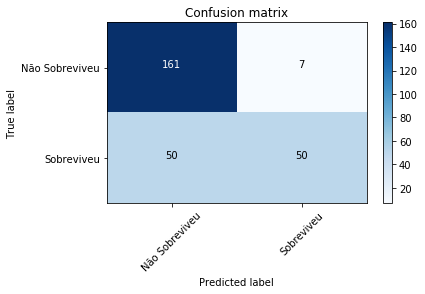

In [82]:
#http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
clf_svc2 = svm.SVC(kernel=clf_svc.best_estimator_.kernel,
                   C=clf_svc.best_estimator_.C,
                   degree=clf_svc.best_estimator_.degree, 
                   gamma=clf_svc.best_estimator_.gamma, 
                   coef0=0.0, 
                   shrinking=True, 
                   probability=False, 
                   tol=0.001, 
                   cache_size=200, 
                   class_weight=None, 
                   verbose=False, 
                   max_iter=-1, 
                   random_state=0).fit(X_traincv, y_traincv)

roc_svc2 = clf_eval(clf_svc2, X_testcv, y_testcv)

For this first classifier, we'll also display the learning curve  
http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.learning_curve.html  

In [83]:
#http://scikit-learn.org/stable/modules/generated/sklearn.learning_curve.learning_curve.html

def plot_learning_curve(estimator, 
                        title, 
                        X, 
                        y, 
                        ylim=None, 
                        cv=None,
                        n_jobs=-1, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure(figsize=(16,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = model_selection.learning_curve(estimator, 
                                                            X, y, cv=cv, 
                                                            n_jobs=n_jobs, 
                                                            train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

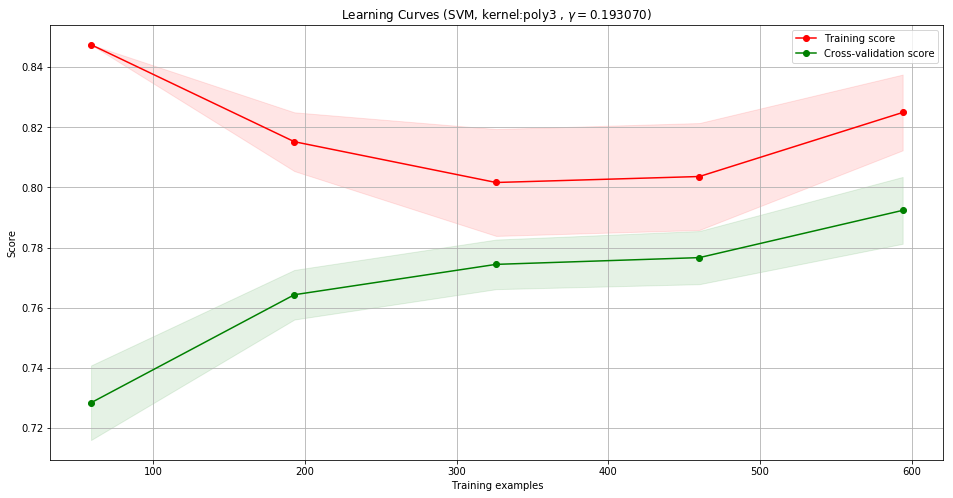

In [84]:
title = 'Learning Curves (SVM, kernel:{1}{0} , $\gamma={2:.6f}$)'.format(clf_svc.best_estimator_.degree,
                                                                         clf_svc.best_estimator_.kernel,
                                                                         clf_svc.best_estimator_.gamma)
graph = plot_learning_curve(clf_svc2, title, X_train, y_train, cv=cv)
#matplotlib.rcdefaults()
#matplotlib.verbose.set_level('silent')
graph.show()

#### Logistic Regression

Logistic regression, or logit regression, or logit model is a regression model where the dependent variable (DV) is categorical. In the binary case, a dependent variable (the output) can take only two values, "0" and "1", which represent outcomes such as pass/fail, win/lose, alive/dead or healthy/sick. Cases where the dependent variable has more than two outcome categories may be analysed in multinomial logistic regression, or, if the multiple categories are ordered, in ordinal logistic regression.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.88      0.86       168
    Sobreviveu       0.78      0.72      0.75       100

   avg / total       0.82      0.82      0.82       268

ROC Score: 0.8004761904761905
Accuracy Score: 0.8208955223880597
Average Precision Score: 0.6679558728098637
f1 Score: 0.7499999999999999
Confusion matrix, without normalization
[[148  20]
 [ 28  72]]


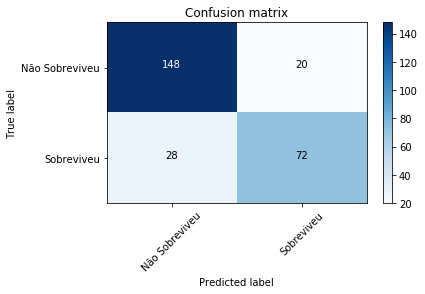

In [85]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(penalty='l2',
                            dual=False, 
                            tol=0.001, 
                            C=0.10, 
                            fit_intercept=True, 
                            intercept_scaling=1, 
                            class_weight=None, 
                            random_state=0, 
                            solver='saga', 
                            max_iter=100, 
                            multi_class='ovr', 
                            verbose=0, 
                            warm_start=False, 
                            n_jobs=-1).fit(X_traincv, y_traincv)

roc_lr = clf_eval(clf_lr, X_testcv, y_testcv)

##### Assessing the importance of the features

Index(['Pclass', 'SibSp', 'Parch', 'Fare', 'Gender', 'AgeFill', 'Emb1', 'Emb2',
       'Emb3', 'Deck', 'FamilySize', 'Age*Class'],
      dtype='object')
Gender       -1.143131
Pclass       -0.505606
Age*Class    -0.371565
SibSp        -0.283984
AgeFill      -0.233642
FamilySize   -0.176745
Emb3         -0.084230
Deck         -0.064086
Emb2          0.032338
Parch         0.034725
Emb1          0.072830
Fare          0.073280
dtype: float64


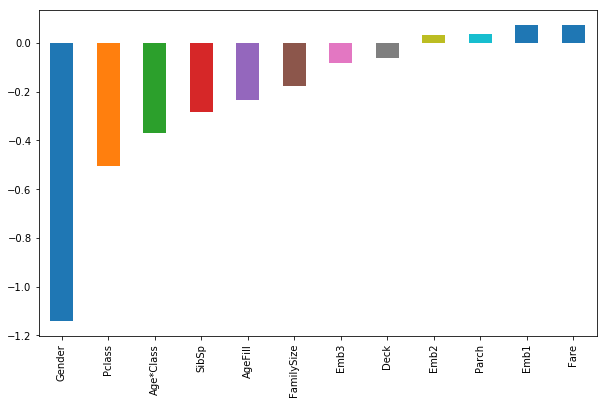

In [86]:
coefs = pd.Series(clf_lr.coef_[0], index=df_train2.columns[2:])
print(df_train2.columns[2:])
coefs = coefs.sort_values()
coefs.plot(kind="bar", figsize=(10,6))
print(coefs.sort_values(ascending = True))

##### Precision Recall Curve

For each person the classifier algorithm has to classify, it computes a probability based on a function and it classifies the person as survived (when the score is bigger the than threshold) or as not survived (when the score is smaller than the threshold). That’s why the threshold plays an important part.

We will plot the precision and recall with the threshold using matplotlib:

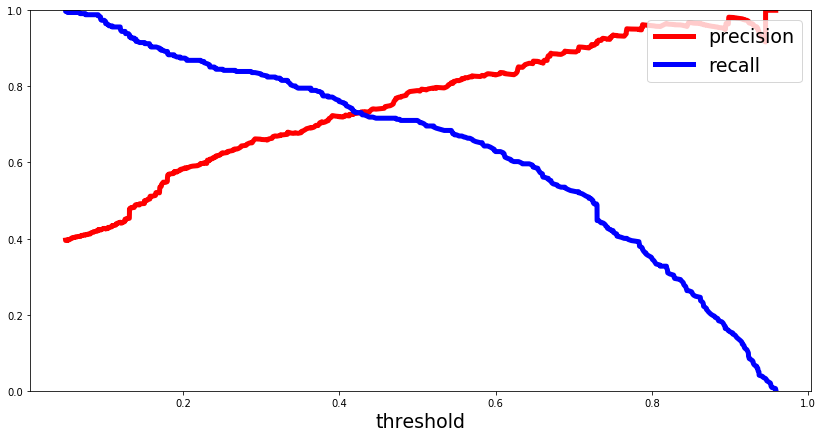

In [87]:
# getting the probabilities of our predictions
y_scores = clf_lr.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(y_train, y_scores)

def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

Another way is to plot the precision and recall against each other:

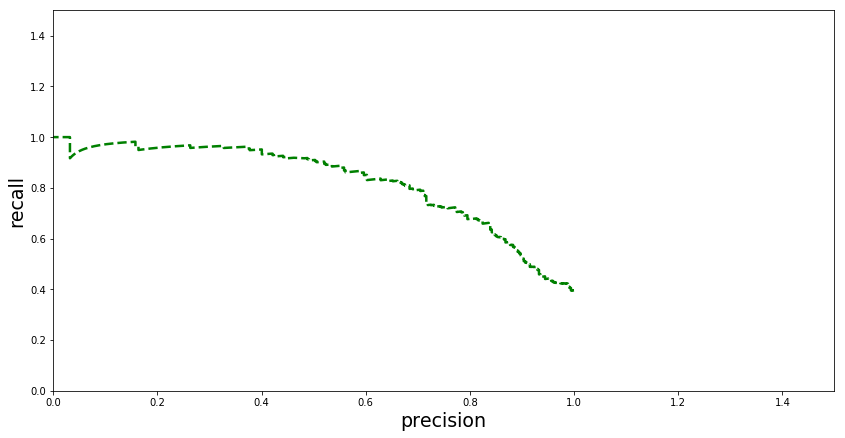

In [88]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

#### Ridge Classifier

Ridge Classifiers addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of coefficients. The ridge coefficients minimize a penalized residual sum of squares

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.86      0.85       168
    Sobreviveu       0.75      0.72      0.73       100

   avg / total       0.80      0.81      0.81       268

ROC Score: 0.7885714285714286
Accuracy Score: 0.8059701492537313
Average Precision Score: 0.6444776119402985
f1 Score: 0.7346938775510204
Confusion matrix, without normalization
[[144  24]
 [ 28  72]]


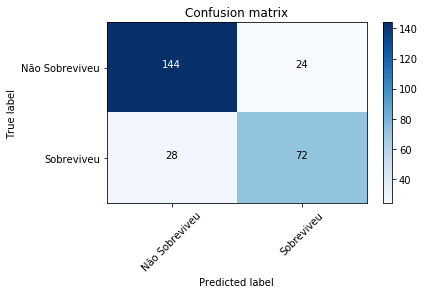

In [89]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
from sklearn.linear_model import RidgeClassifier

clf_rdg = RidgeClassifier(alpha=1.0, 
                          fit_intercept=True, 
                          normalize=False, 
                          copy_X=True, 
                          max_iter=None, 
                          tol=0.001, 
                          class_weight=None, 
                          solver='auto', 
                          random_state=0).fit(X_traincv, y_traincv)

roc_rdg = clf_eval(clf_rdg, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.83      0.85      0.84       168
    Sobreviveu       0.74      0.71      0.72       100

   avg / total       0.80      0.80      0.80       268

ROC Score: 0.780595238095238
Accuracy Score: 0.7985074626865671
Average Precision Score: 0.6333131218905473
f1 Score: 0.7244897959183674
Confusion matrix, without normalization
[[143  25]
 [ 29  71]]


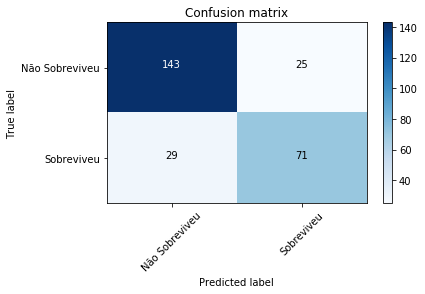

In [90]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
from sklearn.linear_model import RidgeClassifierCV

clf_rdgcv = RidgeClassifierCV(alphas=(0.1, 1.0, 10.0), 
                            fit_intercept=True, 
                            normalize=False, 
                            scoring=None, 
                            cv=None, 
                            class_weight=None).fit(X_traincv, y_traincv)


roc_rdgcv = clf_eval(clf_rdgcv, X_testcv, y_testcv)

#### Perceptron 

Perceptron is an algorithm for supervised learning of binary classifiers (functions that can decide whether an input, represented by a vector of numbers, belongs to some specific class or not). It is a type of linear classifier, i.e. a classification algorithm that makes its predictions based on a linear predictor function combining a set of weights with the feature vector. The algorithm allows for online learning, in that it processes elements in the training set one at a time.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.81      0.70      0.75       168
    Sobreviveu       0.59      0.73      0.65       100

   avg / total       0.73      0.71      0.71       268

ROC Score: 0.7132142857142857
Accuracy Score: 0.7089552238805971
Average Precision Score: 0.5305043331728454
f1 Score: 0.6517857142857142
Confusion matrix, without normalization
[[117  51]
 [ 27  73]]


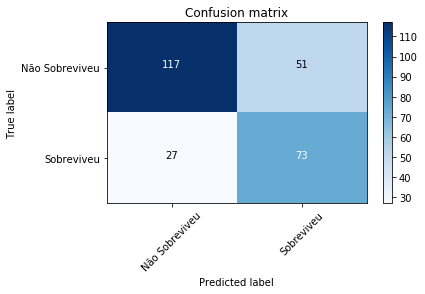

In [91]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron
from sklearn.linear_model import Perceptron

clf_pcp = Perceptron(penalty=None,
                     alpha=0.001,
                     fit_intercept=True,
                     max_iter=230,
                     shuffle=True,
                     verbose=0,
                     eta0=1.0,
                     n_jobs=-1, 
                     random_state=0, 
                     class_weight=None, 
                     warm_start=False).fit(X_traincv, y_traincv)

roc_pcp = clf_eval(clf_pcp, X_testcv, y_testcv)

#### Passive Aggressive

Passive Aggressive Algorithms are a family of online learning algorithms (for both classification and regression) proposed by Crammer at al. The idea is very simple and their performance has been proofed to be superior to many other alternative methods like Online Perceptron and MIRA (see the original paper in the reference section). Passive: if correct classification, keep the model; Aggressive: if incorrect classification, update to adjust to this misclassified example. In my mind, in passive, the information hidden in the example is not enough for updating; in aggressive, the information shows that at lest this time you are wrong, a better model should modify this mistake.  

https://www.bonaccorso.eu/2017/10/06/ml-algorithms-addendum-passive-aggressive-algorithms/  

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.86      0.79      0.83       168
    Sobreviveu       0.69      0.79      0.74       100

   avg / total       0.80      0.79      0.79       268

ROC Score: 0.7908333333333333
Accuracy Score: 0.7910447761194029
Average Precision Score: 0.6258143493061011
f1 Score: 0.7383177570093459
Confusion matrix, without normalization
[[133  35]
 [ 21  79]]


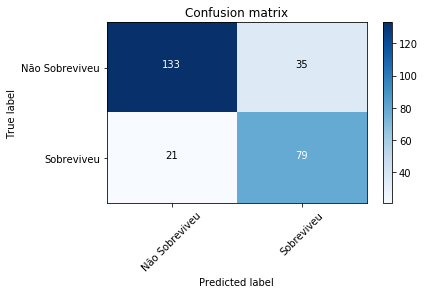

In [92]:
#http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html
from sklearn.linear_model import PassiveAggressiveClassifier

clf_pac = PassiveAggressiveClassifier(C=0.1, 
                                      fit_intercept=True, 
                                      max_iter=100, 
                                      shuffle=True, 
                                      verbose=0, 
                                      loss='hinge', 
                                      n_jobs=-1, 
                                      random_state=0, 
                                      warm_start=False, 
                                      class_weight=None).fit(X_traincv, y_traincv)

roc_pac = clf_eval(clf_pac, X_testcv, y_testcv)

#### SGDC Classifier

The SGDC classifier is a linear classifier (SVM, logistic regression) with SGD training. Implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate). SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.  

The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net). If the parameter update crosses the 0.0 value because of the regularizer, the update is truncated to 0.0 to allow for learning sparse models and achieve online feature selection.  

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.81      0.86      0.83       168
    Sobreviveu       0.73      0.66      0.69       100

   avg / total       0.78      0.78      0.78       268

ROC Score: 0.7585714285714287
Accuracy Score: 0.7835820895522388
Average Precision Score: 0.6108656716417911
f1 Score: 0.6947368421052631
Confusion matrix, without normalization
[[144  24]
 [ 34  66]]


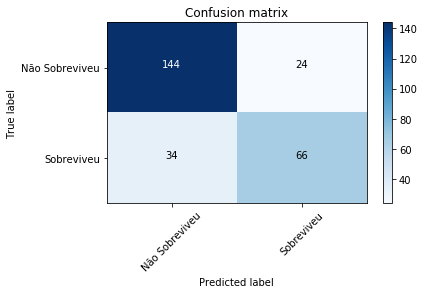

In [93]:
from sklearn.linear_model import SGDClassifier

clf_sgdc = SGDClassifier(loss='hinge',
                         penalty='l2', 
                         alpha=0.0001,
                         l1_ratio=0.15, 
                         fit_intercept=True,
                         max_iter=200, 
                         shuffle=True,
                         verbose=0,
                         epsilon=0.1,
                         n_jobs=-1,
                         random_state=0,
                         learning_rate='optimal',
                         eta0=0.0, 
                         power_t=0.5,
                         class_weight=None,
                         warm_start=False, 
                         average=False).fit(X_traincv, y_traincv)

roc_sgdc = clf_eval(clf_sgdc, X_testcv, y_testcv)

#### k-Nearest Neighbors

k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification and regression. In both cases, the input consists of the k closest training examples in the feature space. The output depends on whether k-NN is used for classification or regression:

+ In k-NN classification, the output is a class membership. An object is classified by a majority vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor.

+ In k-NN regression, the output is the property value for the object. This value is the average of the values of its k nearest neighbors.

k-NN is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until classification. The k-NN algorithm is among the simplest of all machine learning algorithms.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.85      0.84      0.85       168
    Sobreviveu       0.74      0.76      0.75       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.7996428571428571
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6503289378350964
f1 Score: 0.7487684729064039
Confusion matrix, without normalization
[[141  27]
 [ 24  76]]


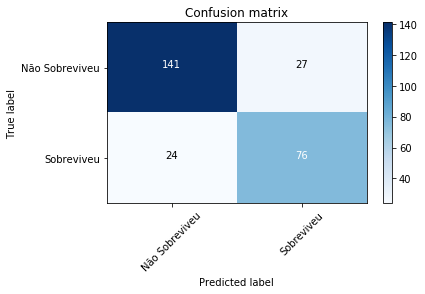

In [94]:
from sklearn.neighbors import KNeighborsClassifier

clf_knn = KNeighborsClassifier(n_neighbors=25,
                               weights='uniform', 
                               algorithm='auto', 
                               leaf_size=30, 
                               p=4, 
                               metric='minkowski', 
                               metric_params=None, 
                               n_jobs=-1).fit(X_traincv, y_traincv)

roc_knn = clf_eval(clf_knn, X_testcv, y_testcv)

#### Decision Trees

Decision tree learning uses a decision tree (as a predictive model) to go from observations about an item (represented in the branches) to conclusions about the item's target value (represented in the leaves). Tree models where the target variable can take a discrete set of values are called classification trees; in these tree structures, leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.83      0.88      0.85       168
    Sobreviveu       0.77      0.69      0.73       100

   avg / total       0.80      0.81      0.80       268

ROC Score: 0.7825
Accuracy Score: 0.8059701492537313
Average Precision Score: 0.6446716417910449
f1 Score: 0.7263157894736842
Confusion matrix, without normalization
[[147  21]
 [ 31  69]]


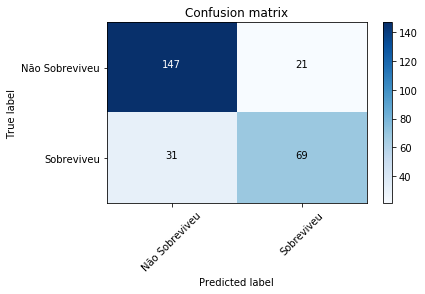

In [95]:
# http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.tree import DecisionTreeClassifier

clf_dtc = DecisionTreeClassifier(criterion='gini', 
                                 splitter='best', 
                                 max_depth=None, 
                                 min_samples_split=3, 
                                 min_samples_leaf=1, 
                                 min_weight_fraction_leaf=0.0, 
                                 max_features=None, 
                                 random_state=0, 
                                 max_leaf_nodes=None, 
                                 class_weight=None, 
                                 presort=False).fit(X_traincv, y_traincv)

roc_dtc = clf_eval(clf_dtc, X_testcv, y_testcv)

### Ensemble Classifiers

A linear classifier achieves this by making a classification decision based on the value of a linear combination of the characteristics. An object's characteristics are also known as feature values and are typically presented to the machine in a vector called a feature vector. Such classifiers work well for practical problems such as document classification, and more generally for problems with many variables (features), reaching accuracy levels comparable to non-linear classifiers while taking less time to train and use.

We have many type of ensembles: Bagging, Boosting, Voting and Stacking  

#### Bagging

Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach. Random Forests are the most common type of bagging algorithms.

#### Random Forests

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks, that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.86      0.85       168
    Sobreviveu       0.76      0.72      0.74       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.791547619047619
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6501618224666142
f1 Score: 0.7384615384615385
Confusion matrix, without normalization
[[145  23]
 [ 28  72]]


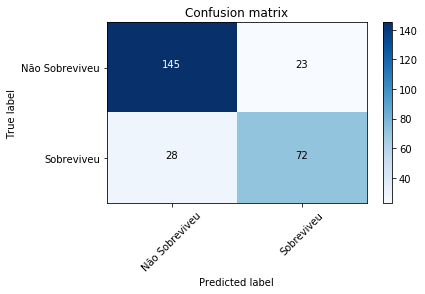

In [96]:
#http://scikit-learn.org/stable/modules/ensemble.html
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
#http://blog.yhathq.com/posts/random-forests-in-python.html
#http://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=3, #2,
                                min_samples_leaf=1, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=0, 
                                warm_start=False, 
                                class_weight=None).fit(X_traincv, y_traincv)



roc_rf = clf_eval(clf_rf, X_testcv, y_testcv)

##### Assessing the importance of the features

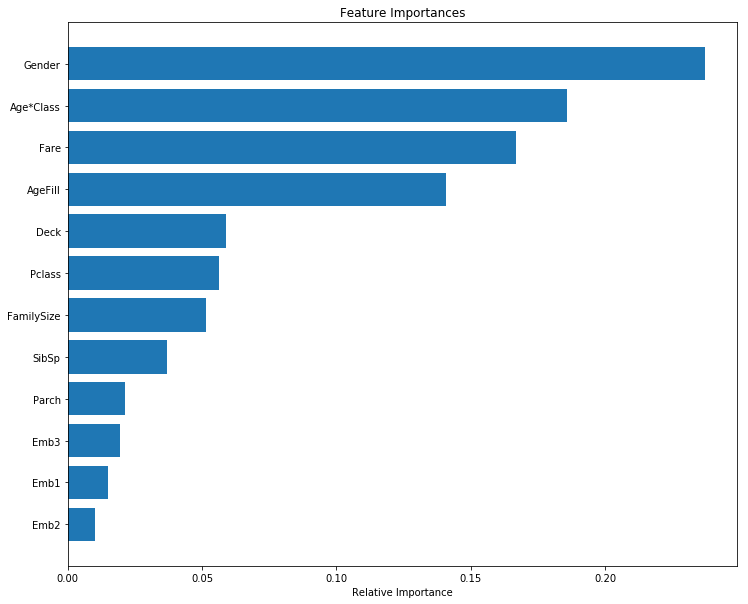

In [97]:
features = df_train2.columns[2:]
importances = clf_rf.feature_importances_
indices = np.argsort(importances) #[0:9])  # top 10 features
plt.figure(figsize=(12,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

##### Plotting the confidence intervals  
https://github.com/scikit-learn-contrib/forest-confidence-interval  

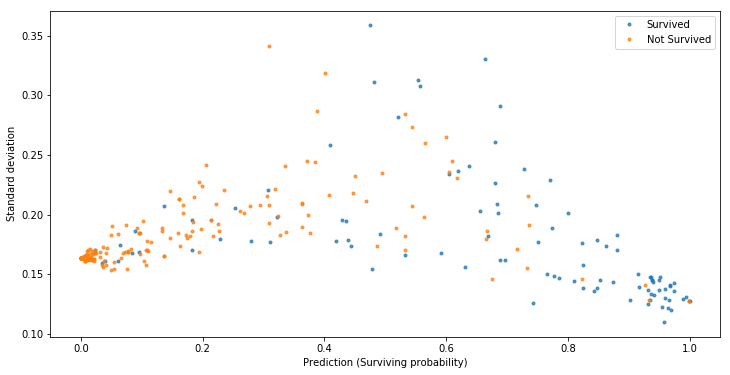

In [98]:
import forestci as fci

y_predicted = clf_rf.predict_proba(X_testcv)

# calculate inbag and unbiased variance
inbag = fci.calc_inbag(X_traincv.shape[0], clf_rf)
unbiased = fci.random_forest_error(clf_rf, X_traincv, X_testcv, inbag)

# Plot forest prediction for survivors and standard deviation for estimates
# Blue points are survivors; Green points are non-survivors
idx = np.where(y_testcv == 1)[0]

plt.figure(figsize=(12,6))
plt.errorbar(y_predicted[idx, 1], 
             np.sqrt(unbiased[idx]),
             fmt='.', 
             alpha=0.75, 
             label='Survived')

idx = np.where(y_testcv == 0)[0]
plt.errorbar(y_predicted[idx, 1],
             np.sqrt(unbiased[idx]),
             fmt='.', 
             alpha=0.75, 
             label='Not Survived')

plt.xlabel('Prediction (Surviving probability)')
plt.ylabel('Standard deviation')
plt.legend()
plt.show()

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.79      0.86      0.82       168
    Sobreviveu       0.72      0.62      0.67       100

   avg / total       0.76      0.77      0.76       268

ROC Score: 0.7385714285714287
Accuracy Score: 0.7686567164179104
Average Precision Score: 0.5887677889621659
f1 Score: 0.6666666666666666
Confusion matrix, without normalization
[[144  24]
 [ 38  62]]


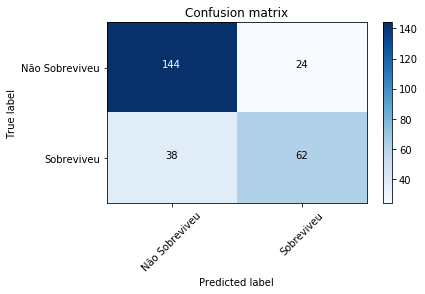

In [99]:
from sklearn.ensemble import BaggingClassifier

clf_bgc = BaggingClassifier().fit(X_traincv, y_traincv)

roc_bgc = clf_eval(clf_bgc, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.86      0.85       168
    Sobreviveu       0.75      0.73      0.74       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.7935714285714286
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6501277119556855
f1 Score: 0.7411167512690355
Confusion matrix, without normalization
[[144  24]
 [ 27  73]]


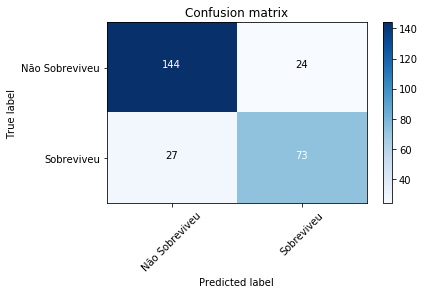

In [100]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
from sklearn.ensemble import ExtraTreesClassifier

clf_etc = ExtraTreesClassifier(n_estimators=300,
                               max_depth=None,
                               min_samples_split=3,
                               random_state=0).fit(X_traincv, y_traincv)

roc_etc = clf_eval(clf_etc, X_testcv, y_testcv)

#### Boosting

Boosting is a machine learning ensemble meta-algorithm for primarily reducing bias, and also variance in supervised learning, and a family of machine learning algorithms that convert weak learners to strong ones. Boosting is based on the question posed by Kearns and Valiant (1988, 1989): Can a set of weak learners create a single strong learner? A weak learner is defined to be a classifier that is only slightly correlated with the true classification (it can label examples better than random guessing). In contrast, a strong learner is a classifier that is arbitrarily well-correlated with the true classification.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.85      0.88      0.87       168
    Sobreviveu       0.79      0.74      0.76       100

   avg / total       0.83      0.83      0.83       268

ROC Score: 0.8104761904761905
Accuracy Score: 0.8283582089552238
Average Precision Score: 0.6795681168624961
f1 Score: 0.7628865979381443
Confusion matrix, without normalization
[[148  20]
 [ 26  74]]


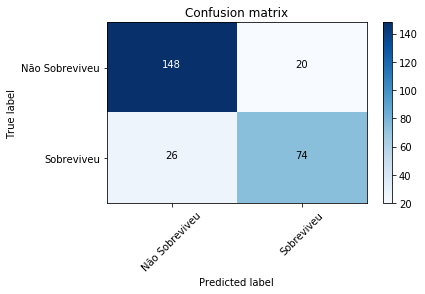

In [101]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
from sklearn.ensemble import AdaBoostClassifier

clf_abc = AdaBoostClassifier(base_estimator=None,
                             n_estimators=300,
                             learning_rate=0.1,
                             algorithm='SAMME.R',
                             random_state=0).fit(X_traincv, y_traincv)

roc_abc = clf_eval(clf_abc, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.86      0.85       168
    Sobreviveu       0.76      0.73      0.74       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.7965476190476192
Accuracy Score: 0.8134328358208955
Average Precision Score: 0.655850435323383
f1 Score: 0.7448979591836735
Confusion matrix, without normalization
[[145  23]
 [ 27  73]]


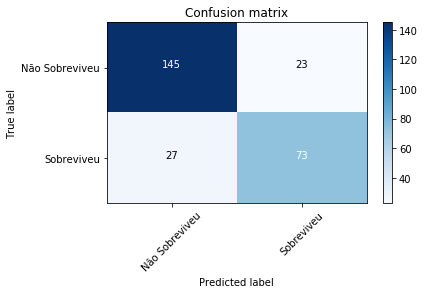

In [102]:
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
from sklearn.ensemble import GradientBoostingClassifier

clf_gbc = GradientBoostingClassifier(loss='deviance',
                                     learning_rate=0.1,
                                     n_estimators=200,
                                     subsample=1.0, 
                                     min_samples_split=3, 
                                     min_samples_leaf=1, 
                                     min_weight_fraction_leaf=0.0, 
                                     max_depth=3, 
                                     init=None, 
                                     random_state=0, 
                                     max_features=None, 
                                     verbose=0, 
                                     max_leaf_nodes=None, 
                                     warm_start=False, 
                                     presort='auto').fit(X_traincv, y_traincv)

roc_gbc = clf_eval(clf_gbc, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.83      0.95      0.88       168
    Sobreviveu       0.88      0.67      0.76       100

   avg / total       0.85      0.84      0.84       268

ROC Score: 0.8082142857142857
Accuracy Score: 0.8432835820895522
Average Precision Score: 0.7137922230950511
f1 Score: 0.7613636363636364
Confusion matrix, without normalization
[[159   9]
 [ 33  67]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


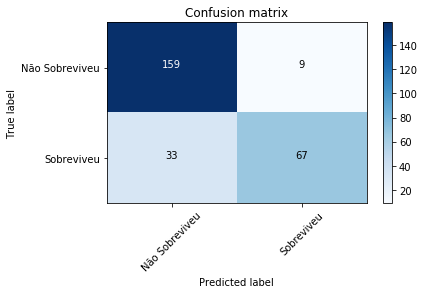

In [103]:
#https://github.com/dmlc/xgboost/tree/master/python-package  
#https://xgboost.readthedocs.io/en/latest/build.html#building-on-ubuntu-debian
#http://xgboost.readthedocs.io/en/latest/build.html#python-package-installation  
#http://xgboost.readthedocs.io/en/latest/parameter.html  
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
#https://www.kaggle.com/cbrogan/titanic/xgboost-example-python/run/1620  
#http://xgboost.readthedocs.io/en/latest//python/python_api.html#module-xgboost.sklearn

import xgboost

clf_xgb = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=2,
                                        min_child_weight=1,
                                        missing=None,
                                        gamma=0.1,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,
                                        random_state=0).fit(X_traincv, y_traincv)

roc_xgb = clf_eval(clf_xgb, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.83      0.88      0.85       168
    Sobreviveu       0.77      0.70      0.73       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.7875
Accuracy Score: 0.8097014925373134
Average Precision Score: 0.6504018369690011
f1 Score: 0.7329842931937172
Confusion matrix, without normalization
[[147  21]
 [ 30  70]]


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


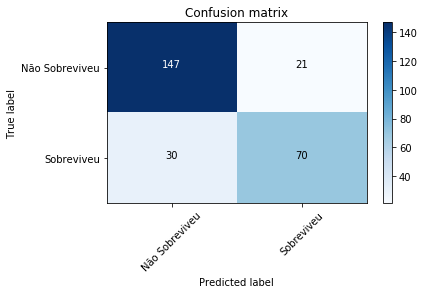

In [105]:
import lightgbm as lgb

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'binary',
          'num_leaves': 64, 
          'learning_rate': 0.05, 
          'max_bin': 512, 
          'subsample_for_bin': 200,
          'subsample': 1, 
          'subsample_freq': 1, 
          'colsample_bytree': 0.8, 
          'reg_alpha': 5, 
          'reg_lambda': 10,
          'min_split_gain': 0.15, 
          'min_child_weight': 1, 
          'min_child_samples': 5, 
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'binary_error'}

lgb_train = lgb.Dataset(X_traincv, y_traincv)
lgb_eval = lgb.Dataset(X_testcv, y_testcv, reference=lgb_train)

clf_lgb = lgb.LGBMClassifier(boosting_type= 'gbdt',
                             objective = 'binary',
                             n_jobs = -1,
                             silent = True,
                             max_depth = params['max_depth'],
                             max_bin = params['max_bin'],
                             subsample_for_bin = params['subsample_for_bin'],
                             subsample = params['subsample'],
                             subsample_freq = params['subsample_freq'],
                             min_split_gain = params['min_split_gain'], 
                             min_child_weight = params['min_child_weight'], 
                             min_child_samples = params['min_child_samples'], 
                             scale_pos_weight = params['scale_pos_weight'])

clf_lgb.fit(X_traincv, y_traincv)


roc_lgb = clf_eval(clf_lgb, X_testcv, y_testcv)

#### Regularized Greedy Forest

In Boosting algorithms, each classifier/regressor is trained on data, taking into account the previous classifiers’/regressors’ success. After each training step, the weights are redistributed. Mis-classified data increases its weights to emphasize the most difficult cases. In this way, subsequent learners will focus on them during their training. However, the boosting methods simply treat the decision tree base learner as a black box and it does not take advantage of the tree structure itself.  In a sense, boosting does a partial corrective step to the model at each iteration. In contrast, RGF performs 2 steps:

+ Finds the one step structural change to the current forest to obtain the new forest that minimises the loss function (e.g. Least squares or logloss)
+ Adjusts the leaf weights for the entire forest to minimize the loss function

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.85      0.92      0.88       168
    Sobreviveu       0.85      0.72      0.78       100

   avg / total       0.85      0.85      0.84       268

ROC Score: 0.8213095238095238
Accuracy Score: 0.8470149253731343
Average Precision Score: 0.7143599648814749
f1 Score: 0.7783783783783784
Confusion matrix, without normalization
[[155  13]
 [ 28  72]]


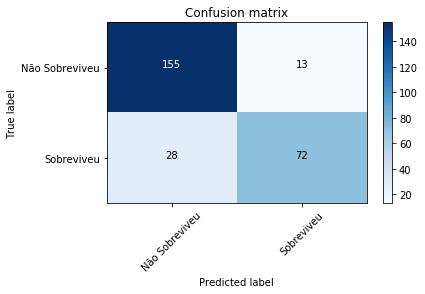

In [106]:
# https://www.analyticsvidhya.com/blog/2018/02/introductory-guide-regularized-greedy-forests-rgf-python/
# https://github.com/fukatani/rgf_python
#https://github.com/MLWave/RGF-sklearn -- another implementation
##https://github.com/RGF-team/rgf_python -- another implementation

from rgf.sklearn import RGFClassifier, FastRGFClassifier

clf_rgf = RGFClassifier(max_leaf=240,
                        algorithm="RGF_Sib",
                        test_interval=100,
                        verbose=False,).fit(X_traincv, y_traincv)

roc_rgf = clf_eval(clf_rgf, X_testcv, y_testcv)

#### Bayesian Classifiers

Naive Bayes classifiers are a family of simple probabilistic classifiers based on applying Bayes theorem with strong (naive) independence assumptions between the features. Naive Bayes classifiers are highly scalable, requiring a number of parameters linear in the number of variables (features/predictors) in a learning problem. Maximum-likelihood training can be done by evaluating a closed-form expression, which takes linear time, rather than by expensive iterative approximation as used for many other types of classifiers.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.84      0.77      0.80       168
    Sobreviveu       0.66      0.75      0.70       100

   avg / total       0.77      0.76      0.76       268

ROC Score: 0.7589285714285714
Accuracy Score: 0.7611940298507462
Average Precision Score: 0.5867046347211312
f1 Score: 0.7009345794392524
Confusion matrix, without normalization
[[129  39]
 [ 25  75]]


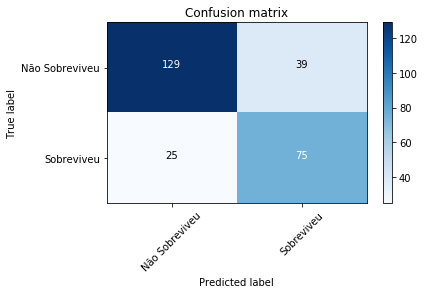

In [107]:
#http://scikit-learn.org/stable/modules/naive_bayes.html
#http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
from sklearn.naive_bayes import GaussianNB

clf_gnb = GaussianNB().fit(X_traincv, y_traincv)

roc_gnb = clf_eval(clf_gnb, X_testcv, y_testcv)

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.81      0.82      0.81       168
    Sobreviveu       0.68      0.67      0.68       100

   avg / total       0.76      0.76      0.76       268

ROC Score: 0.7427380952380952
Accuracy Score: 0.7611940298507462
Average Precision Score: 0.5811955528480048
f1 Score: 0.6767676767676768
Confusion matrix, without normalization
[[137  31]
 [ 33  67]]


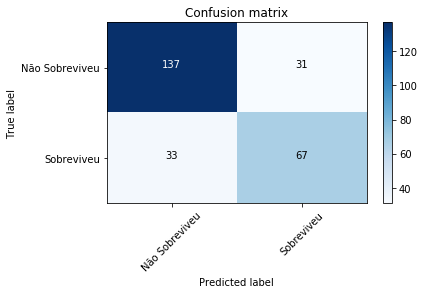

In [108]:
#http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html
from sklearn.naive_bayes import BernoulliNB

clf_bnb = BernoulliNB(alpha=0.20, 
                     binarize=0.0, 
                     fit_prior=True, 
                     class_prior=None).fit(X_traincv, y_traincv)

roc_bnb = clf_eval(clf_bnb, X_testcv, y_testcv)

#### Gaussian Processes

In the simple linear regression setting, we have a dependent variable y that we assume can be modeled as a function of an independent variable x, i.e. y=f(x)+ϵ (where ϵ is the irreducible error) but we assume further that the function f defines a linear relationship and so we are trying to find the parameters θ0  and θ1 which define the intercept and slope of the line respectively, i.e. y=θ0+θ1x+ϵ. Bayesian linear regression provides a probabilistic approach to this by finding a distribution over the parameters that gets updated whenever new data points are observed. The GP approach, in contrast, is a non-parametric approach, in that it finds a distribution over the possible functions f(x) that are consistent with the observed data. As with all Bayesian methods it begins with a prior distribution and updates this as data points are observed, producing the posterior distribution over functions.

Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.82      0.88      0.85       168
    Sobreviveu       0.77      0.67      0.72       100

   avg / total       0.80      0.80      0.80       268

ROC Score: 0.7754761904761904
Accuracy Score: 0.8022388059701493
Average Precision Score: 0.6391113398524618
f1 Score: 0.716577540106952
Confusion matrix, without normalization
[[148  20]
 [ 33  67]]


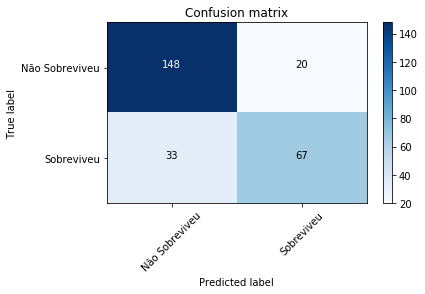

In [109]:
from sklearn.gaussian_process import GaussianProcessClassifier


clf_gpc = GaussianProcessClassifier(kernel=None, 
                                    optimizer='fmin_l_bfgs_b', 
                                    n_restarts_optimizer=0, 
                                    max_iter_predict=100, 
                                    warm_start=False, 
                                    copy_X_train=True, 
                                    random_state=0, 
                                    multi_class='one_vs_rest', 
                                    n_jobs=-1).fit(X_traincv, y_traincv)

roc_gpc = clf_eval(clf_gpc, X_testcv, y_testcv)

#### Neural Networks

A deep neural network (DNN) is an artificial neural network (ANN) with multiple hidden layers between the input and output layers.[9][2] DNNs can model complex non-linear relationships. DNN architectures generate compositional models where the object is expressed as a layered composition of primitives.[97] The extra layers enable composition of features from lower layers, potentially modeling complex data with fewer units than a similarly performing shallow network.  

Keras (with TensorFlow / Theano backends)

Using TensorFlow backend.


Keras using tensorflow backend
623 train samples
268 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               3900      
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 300)               90300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (D

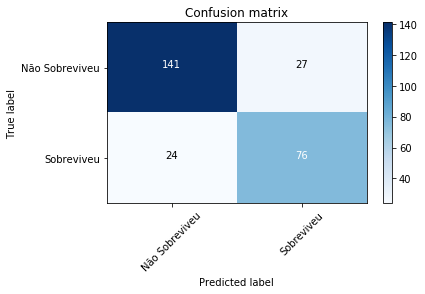

In [110]:
# https://elitedatascience.com/keras-tutorial-deep-learning-in-python
# http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/
# https://www.kaggle.com/cstahl12/titanic/titanic-with-keras

#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, RMSprop
from keras.utils.np_utils import to_categorical

print('Keras using {} backend'.format(keras.backend.backend()))  #https://keras.io/backend/

x_train_kr = X_traincv.astype('float32') 
x_test_kr = X_testcv.astype('float32')

print(x_train_kr.shape[0], 'train samples')
print(x_test_kr.shape[0], 'test samples')

y_train_kr = y_traincv
y_test_kr = y_testcv

# convert class vectors to binary class matrices for categorical cross_entropy
#y_train_kr = to_categorical(y_traincv)
#y_test_kr = to_categorical(y_testcv)

batch_size = int(len(x_test_kr)/15)
num_classes = 2
epochs = 15
np.random.seed(0)

model = Sequential()
model.add(Dense(input_dim=x_train_kr.shape[1], units=300, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=300, units=300, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=300, units=200, activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(input_dim=200, units=24, activation='relu')) #activation='softmax'
model.add(Dropout(0.10))
model.add(Dense(input_dim=24,  units=1, activation='sigmoid')) #kernel_initializer='uniform',
model.summary()


model.compile(loss='binary_crossentropy',
              #loss='categorical_crossentropy',
              #loss='mean_squared_error',
              #optimizer='adam',
              optimizer=RMSprop(), 
              #optimizer=SGD(lr=0.001),
              metrics=['binary_accuracy'])

history = model.fit(x_train_kr, y_train_kr,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=False,
                    validation_data=(x_test_kr, y_test_kr))

score = model.evaluate(x_test_kr, y_test_kr, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


y_pred = model.predict_classes(x_test_kr) #y_pred = np.around(model.predict(x_test_kr)[:,1])
#y_test_kr = y_test_kr[:,1] #for categorical cross_entropy
clf_matrix = confusion_matrix(y_test_kr, y_pred)
print('Classification Report')
print(classification_report(y_test_kr, y_pred, target_names=['Não Sobreviveu', 'Sobreviveu']))
print('ROC Score: {}'.format(roc_auc_score(y_test_kr, y_pred)))
print('Accuracy Score: {}'.format(accuracy_score(y_test_kr, y_pred)))
print('Average Precision Score: {}'.format(average_precision_score(y_test_kr, y_pred)))
print('f1 Score: {}'.format(f1_score(y_test_kr, y_pred)))
plot_confusion_matrix(clf_matrix, classes=['Não Sobreviveu', 'Sobreviveu'])
roc_keras = roc_auc_score(y_test_kr, y_pred)

#### Genetic Algorithms


10.042694683333334 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.
Best pipeline: RandomForestClassifier(RFE(GradientBoostingClassifier(input_matrix, learning_rate=1.0, max_depth=4, max_features=0.9000000000000001, min_samples_leaf=17, min_samples_split=12, n_estimators=100, subsample=0.4), criterion=gini, max_features=0.2, n_estimators=100, step=0.45), bootstrap=True, criterion=entropy, max_features=0.45, min_samples_leaf=7, min_samples_split=19, n_estimators=100)
Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.82      0.90      0.86       168
    Sobreviveu       0.80      0.67      0.73       100

   avg / total       0.81      0.81      0.81       268

ROC Score: 0.7844047619047619
Accuracy Score: 0.8134328358208955
Average Precision Score: 0.6575390902629709
f1 Score: 0.7282608695652173
Confusion matrix, without normalization
[[151  17]
 [ 33  67]]


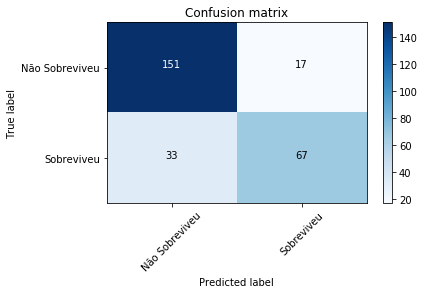

In [111]:
# https://github.com/rhiever/tpot
# https://github.com/rhiever/tpot/blob/master/tutorials/Titanic_Kaggle.ipynb

from tpot import TPOTClassifier

clf_tpot = TPOTClassifier(verbosity=1, 
                          max_time_mins=10, 
                          max_eval_time_mins=5, 
                          population_size=100,
                          generations=10,
                          n_jobs=-1)

clf_tpot.fit(X_traincv, y_traincv)
roc_tpot = clf_eval(clf_tpot, X_testcv, y_testcv)

#clf_tpot.export('tpot_exported_pipeline.py')

[WARNING] [2018-09-20 21:13:21,362:EnsembleBuilder(0):6133d52dcbee7ceaa8cbcd510562f80f] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-20 21:13:21,368:EnsembleBuilder(0):6133d52dcbee7ceaa8cbcd510562f80f] No models better than random - using Dummy Classifier!
Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.85      0.88      0.86       168
    Sobreviveu       0.78      0.74      0.76       100

   avg / total       0.82      0.82      0.82       268

ROC Score: 0.8075
Accuracy Score: 0.8246268656716418
Average Precision Score: 0.6734359780047132
f1 Score: 0.7589743589743589
Confusion matrix, without normalization
[[147  21]
 [ 26  74]]


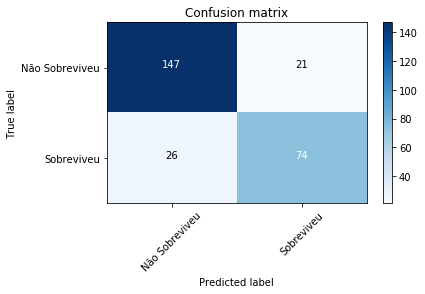

In [137]:
# https://github.com/automl/auto-sklearn
# http://automl.github.io/auto-sklearn/stable/api.html#classification

import autosklearn.classification
clf_autoskl = autosklearn.classification.AutoSklearnClassifier(time_left_for_this_task=5*60,
                                                               per_run_time_limit=1*60,
                                                               seed=0)
#clf_autoskl.get_params(deep=True)
#clf_autoskl.fit(X_traincv, y_traincv, metric=autosklearn.metrics.accuracy)

#avoid many warnings in the current version ***
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
#avoid many warnings in the current version ***
    clf_autoskl.fit(X_traincv, y_traincv, metric=autosklearn.metrics.balanced_accuracy)

clf_autoskl.get_models_with_weights()
roc_autoskl = clf_eval(clf_autoskl, X_testcv, y_testcv)

#### Voting / Stacking

Voting algorithms are simple strategies, where you aglomerate results of classifiers' decisions by for example taking the class which appears in most cases. 

Stacking/grading strategies are generalizations of this concept. Instead of simply saying "ok, I have a scheme v, which I will use to select the best answer among my k classifiers" you create another abstraction layer, where you actually learn to predict the correct label having k votes.  

[WARNING] [2018-09-20 21:18:18,944:EnsembleBuilder(0):6133d52dcbee7ceaa8cbcd510562f80f] No models better than random - using Dummy Classifier!
[WARNING] [2018-09-20 21:18:18,950:EnsembleBuilder(0):6133d52dcbee7ceaa8cbcd510562f80f] No models better than random - using Dummy Classifier!


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Classification Report
                precision    recall  f1-score   support

Não Sobreviveu       0.86      0.89      0.88       168
    Sobreviveu       0.81      0.76      0.78       100

   avg / total       0.84      0.84      0.84       268

ROC Score: 0.8264285714285715
Accuracy Score: 0.8432835820895522
Average Precision Score: 0.7040203239123531
f1 Score: 0.7835051546391754
Confusion matrix, without normalization
[[150  18]
 [ 24  76]]


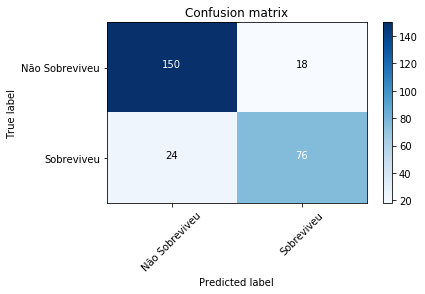

In [138]:
from sklearn.ensemble import VotingClassifier 
#http://scikit-learn.org/stable/modules/ensemble.html#votingclassifier

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    ensemble = VotingClassifier(estimators=[('clf_sgdc', clf_sgdc),
                                            ('clf_lgr', clf_lr),
                                            ('clf_rdg', clf_rgf),
                                            ('clf_bgc', clf_bgc),
                                            ('clf_etc', clf_etc),
                                            ('clf_abc', clf_abc),
                                            ('clf_pct', clf_pcp),
                                            ('clf_xgb', clf_xgb),
                                            ('clf_rf', clf_rf),
                                            ('clf_knn', clf_knn),
                                            ('clf_rgf', clf_rgf),
                                            ('clf_autoskl', clf_autoskl),
                                            #('clf_tpot', clf_tpot),
                                            ],
                                voting='hard',
                                weights=[1,1,1,1,1,1,1,1,1,1,2,1]).fit(X_traincv, y_traincv)

roc_ens = clf_eval(ensemble, X_testcv, y_testcv)

### Plotting the results:  

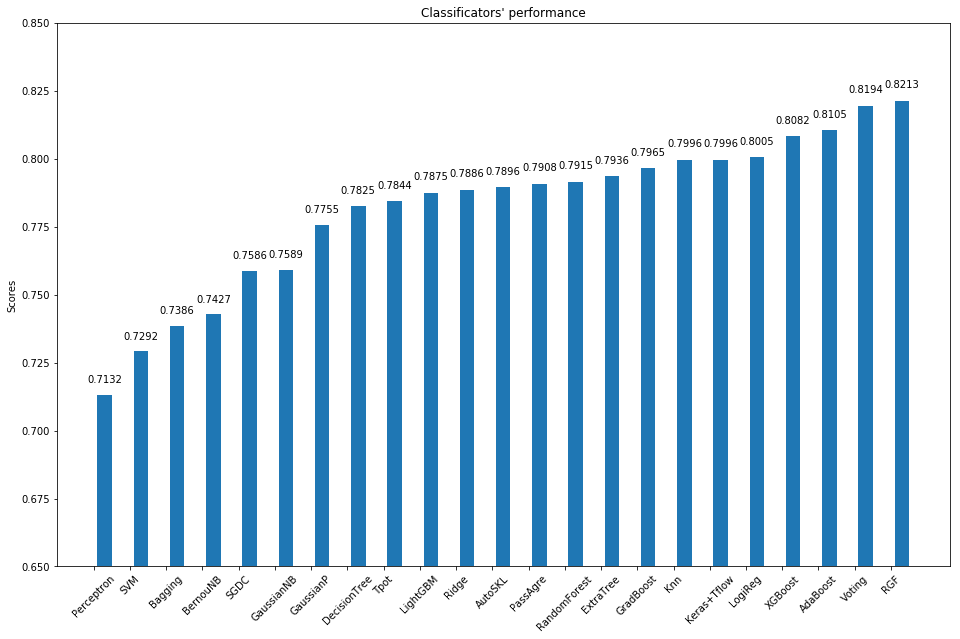

In [114]:
dic_results = {'SVM': roc_svc2,
               'RandomForest': roc_rf,
               'DecisionTree': roc_dtc,
               'ExtraTree': roc_etc,
               'AdaBoost': roc_abc,
               'GradBoost': roc_gbc,
               'LightGBM': roc_lgb,
               'SGDC': roc_sgdc,
               'Ridge': roc_rdg,
               'Perceptron': roc_pcp,
               'PassAgre': roc_pac,
               'LogiReg': roc_lr,
               'GaussianNB': roc_gnb,
               'BernouNB': roc_bnb,
               'RGF': roc_rgf,
               'XGBoost':roc_xgb,
               'Knn':roc_knn,
               'Keras+Tflow': roc_keras,
               'Bagging': roc_bgc,
               'Voting': roc_ens,
               'Tpot': roc_tpot,
               'RGF': roc_rgf,
               'AutoSKL': roc_autoskl,
               'GaussianP': roc_gpc,
              }

import operator
tup_results = sorted(dic_results.items(), key=operator.itemgetter(1))

N = len(dic_results)
ind = np.arange(N)  # the x locations for the groups
width = 0.40       # the width of the bars

fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
rects = ax.bar(ind+0.5, list(zip(*tup_results))[1], width,)
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2., 
            1.005*height, 
            '{0:.4f}'.format(height), 
            ha='center', 
            va='bottom',)

ax.set_ylabel('Scores')
ax.set_ylim(ymin=0.65,ymax = 0.85)
ax.set_title("Classificators' performance")
ax.set_xticks(ind + width/2.)
ax.set_xticklabels(list(zip(*tup_results))[0], rotation=45)

plt.show()

In [116]:
features = df_train2.columns[2:]
df_fi = pd.DataFrame({'clf_lr': (abs(clf_lr.coef_[0])/sum(abs(clf_lr.coef_[0]))),    #a sort of adaptation
                      'clf_rf':clf_rf.feature_importances_,
                      'clf_xgb':clf_xgb.feature_importances_,
                      'clf_etc':clf_etc.feature_importances_,
                      'clf_abc':clf_abc.feature_importances_,
                      'clf_bgc':clf_bgc.estimators_[0].feature_importances_,
                      'clf_gbc':clf_gbc.feature_importances_,
                      'clf_lgb':clf_lgb.feature_importances_ / sum(clf_lgb.feature_importances_),
                     },
                      index=features)
df_fi['mean_importance'] = df_fi.mean(axis=1)
df_fi.sort_values(['mean_importance'], ascending=False, inplace=True)
df_fi

,clf_lr,clf_rf,clf_xgb,clf_etc,clf_abc,clf_bgc,clf_gbc,clf_lgb,mean_importance
Fare,0.023822,0.166954,0.289548,0.138629,0.203333,0.161507,0.366985,0.331924,0.210338
Age*Class,0.120788,0.185671,0.217514,0.133321,0.240000,0.190507,0.226133,0.230444,0.193047
Gender,0.371610,0.237330,0.070621,0.308340,0.123333,0.292044,0.077442,0.033122,0.189230
AgeFill,0.075952,0.140930,0.220339,0.116589,0.220000,0.137439,0.167447,0.216350,0.161881
Deck,0.020833,0.058781,0.057910,0.059807,0.036667,0.082858,0.025930,0.058492,0.050160
SibSp,0.092318,0.036895,0.035311,0.037656,0.083333,0.045912,0.017669,0.035941,0.048129
Pclass,0.164363,0.056177,0.022599,0.087936,0.013333,0.003606,0.015916,0.019732,0.047958
FamilySize,0.057456,0.051421,0.046610,0.046317,0.043333,0.013709,0.044637,0.036646,0.042516
Emb3,0.027382,0.019413,0.016949,0.017240,0.033333,0.001391,0.018231,0.013390,0.018416
Emb1,0.023675,0.015176,0.012712,0.016805,0.000000,0.038427,0.004778,0.016913,0.016061


Choosing the best classifier and training with all training data:

In [125]:
output = clf_rgf.predict(X_test)
print(output[10:20])
print()

output_prob = clf_rgf.predict_proba(X_test)
print(output_prob[10:20])

[0. 0. 1. 0. 1. 1. 0. 0. 0. 0.]

[[0.77753281 0.22246719]
 [0.73019877 0.26980123]
 [0.05444317 0.94555683]
 [0.91643532 0.08356468]
 [0.07501126 0.92498874]
 [0.08161056 0.91838944]
 [0.84650736 0.15349264]
 [0.84017524 0.15982476]
 [0.72372895 0.27627105]
 [0.80366471 0.19633529]]


#### Examining the ROC Curve

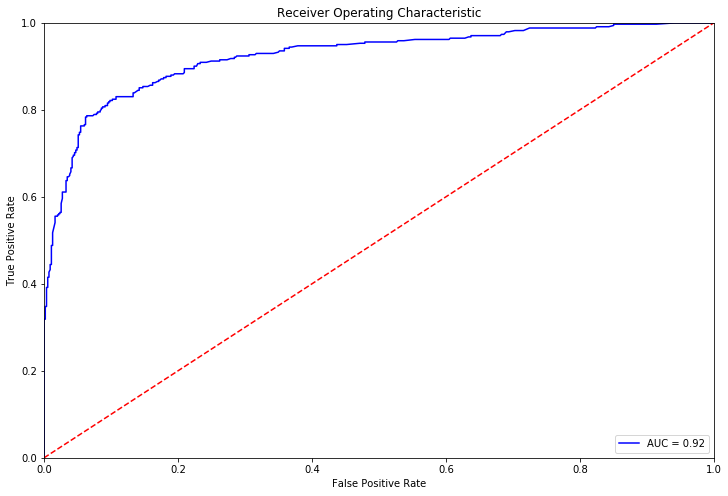

In [134]:
# calculate the fpr and tpr for all thresholds of the classification
probs = clf_rgf.predict_proba(X_train)
y_hat = probs[:,1]
fpr, tpr, threshold = roc_curve(y_train, y_hat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()